In [1]:
from utils.utils import Agent,convert_cost,add,multiply,calculate_total_cost,calculate_daily_budget
from utils.CONSTANT import ITERNERY_GENERATION_TEMPLATE,REQUIREMENT_VALIDATOR,TRAVEL_AGENT_PROMPT,PLANNER_TEMPLATE
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
from langchain.schema import HumanMessage, SystemMessage
from utils.validators import AgentState,AgentRequirement
from utils.weathapi import get_combined_weather_summary
from utils.places_api import get_famous_places_nearby
from utils.hotels import search_hotels

In [2]:
tools=[multiply, add,search_hotels, calculate_total_cost, calculate_daily_budget,get_combined_weather_summary,get_famous_places_nearby,convert_cost]


In [3]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0
)

In [5]:
model = llm.bind_tools(tools)

In [6]:
response =model.invoke("What is the weather from june 20 to june 30 in london")
print(response.tool_calls)


[{'name': 'get_combined_weather_summary', 'args': {'start_date': '2023-06-20', 'end_date': '2023-06-30', 'location': 'London'}, 'id': 'call_mB6HQkh1WzqMGL0kb9V8VfNx', 'type': 'tool_call'}]


In [7]:
response.tool_calls

[{'name': 'get_combined_weather_summary',
  'args': {'start_date': '2023-06-20',
   'end_date': '2023-06-30',
   'location': 'London'},
  'id': 'call_mB6HQkh1WzqMGL0kb9V8VfNx',
  'type': 'tool_call'}]

In [8]:
PLANNER_TEMPLATE

"\n\nYou are an AI Travel Planner and Expense Manager. Your task is to assist users in planning trips to any city worldwide using reasoning and tools.\n\nYou follow the **ReAct pattern**:\n1. Think about what the user needs.\n2. Decide which tool to use and why.\n3. Call the tool using the correct arguments.\n4. Observe the result.\n5. Repeat reasoning and tool usage as needed.\n6. Finally, return a complete, friendly, and well-organized travel plan.\n7. Try Use the provided tools before trying for generic web_search tool\n\nBe thoughtful and structured. Use tools only when required. Wait for tool results before deciding the next step.\n\nIf the user provides a destination and number of days, start by gathering key information like attractions, weather, and hotels. Calculate costs, convert currency, generate an itinerary, and end with a trip summary.\nCorrectly calcuate the trip days and use it for Estimating the cost Always get current coversion rate of the currency  and covert approp

In [9]:
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import tools_condition


In [10]:
builder=StateGraph(MessagesState)
memory=MemorySaver()


In [11]:
def function_1(state:MessagesState):
    
    user_question= state["messages"]
    
    input_question = [ITERNERY_GENERATION_TEMPLATE]+user_question
    
    response = model.invoke(input_question)
    
    return {
        "messages":[response]
    }

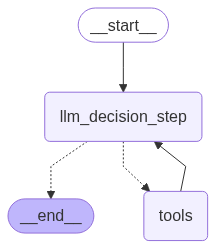

In [12]:
builder.add_node("llm_decision_step",function_1)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_decision_step")
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
builder.add_edge("tools","llm_decision_step")
react_graph=builder.compile()
react_graph

In [13]:
user_input = """I want to visit Milan, Italy from 2025-07-20 to 2025-07-31.
                         - Esitmate the cost of the trip in INR as my transcation currency 
                         - select one hotel under euros 500 which near to the city center, 
                         - please select 5 different local dinining with price range.
                         - I would like to visit 2-3 attractions per day during the stay
                        """
message=[HumanMessage(content=user_input)]


In [14]:
from langchain.globals import set_debug
set_debug(False)


In [15]:
resp=react_graph.invoke({'messages': user_input})


["You are a smart and proactive travel planning assistant with access to the following tools: \n- multiply\n- add\n- search_hotels\n- calculate_total_cost\n- calculate_daily_budget\n- get_combined_weather_summary\n- get_famous_places_nearby\n- convert_cost\n\nYour goal is to generate complete, personalized travel plans that are budget-conscious, weather-informed, and rich in sightseeing opportunities.\n\nWhen a user asks about travel, vacation planning, trip costs, places to visit, or itineraries:\n\n- Use **search_hotels** to find suitable accommodations based on the user's destination, dates, and budget.\n- Use **calculate_total_cost** to estimate total hotel cost based on the number of nights and price per night.\n- Use **convert_cost** to convert costs into the user's local or preferred currency (always check the current exchange rate).\n- Use **calculate_daily_budget** to break down the trip cost per day, including accommodation, food, transport, and extras.\n- Use **get_combined_

In [16]:
for m in resp['messages']:
     m.pretty_print()

================================ Human Message =================================

I want to visit Milan, Italy from 2025-07-20 to 2025-07-31.
                         - Esitmate the cost of the trip in INR as my transcation currency 
                         - select one hotel under euros 500 which near to the city center, 
                         - please select 5 different local dinining with price range.
                         - I would like to visit 2-3 attractions per day during the stay
                        
================================== Ai Message ==================================
Tool Calls:
  search_hotels (call_v130plyt5SjfED3EdVoQL157)
 Call ID: call_v130plyt5SjfED3EdVoQL157
  Args:
    location: Milan, Italy
  get_combined_weather_summary (call_jg3eEypNZrI8paNDC5zLUVar)
 Call ID: call_jg3eEypNZrI8paNDC5zLUVar
  Args:
    start_date: 2025-07-20
    end_date: 2025-07-31
    location: Milan, Italy
================================= Tool Message =====================

In [19]:

resp["messages"][-1].pretty_print()

================================== Ai Message ==================================

## Itinerary for Milan, Italy (July 20 - July 31, 2025)

### Accommodation
- **Hotel Recommendation**: Casa Baglioni
  - **Location**: Brera, Milan's art district, close to Piazza San Babila and Via Montenapoleone.
  - **Features**: Wine bar, full-service spa, vegan and vegetarian options at the restaurant.
  - **Cost**: Under €500 per night (approx. ₹49,896.35 INR).

### Weather Forecast
- **General Overview**: Expect warm temperatures ranging from 29°C to 31°C (84°F to 88°F) with minimal chances of rain. Ideal for sightseeing and outdoor activities.

### Sightseeing
- **Nearby Attractions**:
  - Duomo di Milano
  - San Siro Stadium
  - Sforzesco Castle
  - Galleria Vittorio Emanuele II
  - Basilica di Santa Maria delle Grazie
  - Arco della Pace
  - Pinacoteca di Brera
  - Teatro alla Scala
  - Piazza del Duomo
  - Leonardo da Vinci Museum of Science and Technology

- **Daily Plan**: Visit 2-3 attractio